El TP está bastante bien pero hay que arreglar unas cuantas cosas para la reentrega. Aparte de lo que les
dejo acá, fui dejando comentarios que empiezan con "VALEN:" y "#>" en el notebook y en el código. Me gustaron
los ✅.

- En el 3 del TP1 los mapas son difíciles de interpretar. No queda claro qué representan los colores y los
puntos son bastante chicos. También hay una explicación que está mal y creo que es por eso. Les dejé comentarios.✅(estuve en guerra con este pero quedo mucho mejor)
- metpotI está mal porque InversaLU no tiene la propiedad .shape que después trata de acceder metpot. Háganlo
como hicieron metpotI2 y directamente calculen la inversa. De paso, ese cálculo podrían meterlo en alguna función
específicamente dedicada a calcular la inversa con LU y así ensucian menos el código de metpotI y metpotI2.✅
- En el 1a tienen que mostrar que esas multiplicaciones dan lo que ustedes dicen.✅
- El 2b pedía una demostración general, no probar las cosas con la matriz de ejemplo.✅
- Les faltó dividir por 4 en `calcula_lambda`.✅
- En el 3c vean lo que pasa cuando corren el método del laplaciano varias veces y expliquen.✅
- En el 4 no usaron `laplaciano_iterativo` y calcularon solo el primer corte para cada caso.✅

In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd
import seaborn as sns
import networkx as nx
import scipy as scipy

from Correccion_Funciones import (
    construye_adyacencia,
    calculaLU,
    calcula_matriz_C,
    calcula_pagerank,
    calcula_matriz_C_continua,
    calcula_B,
    calcula_L,
    calcula_R,
    calcula_lambda,
    calcula_Q,
    metpot1,
    metpot2,
    metpotI,
    metpotI2,
    deflaciona,
    laplaciano_iterativo,
    modularidad_iterativo
)


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# @title
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

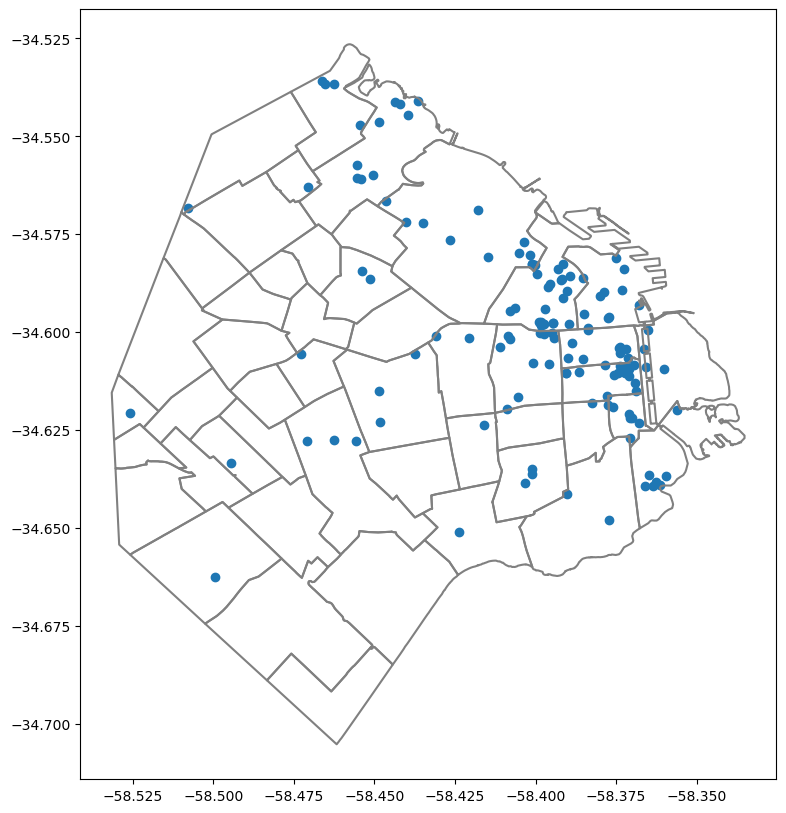

In [3]:
# @title
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# @title
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
# @title
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
# @title
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

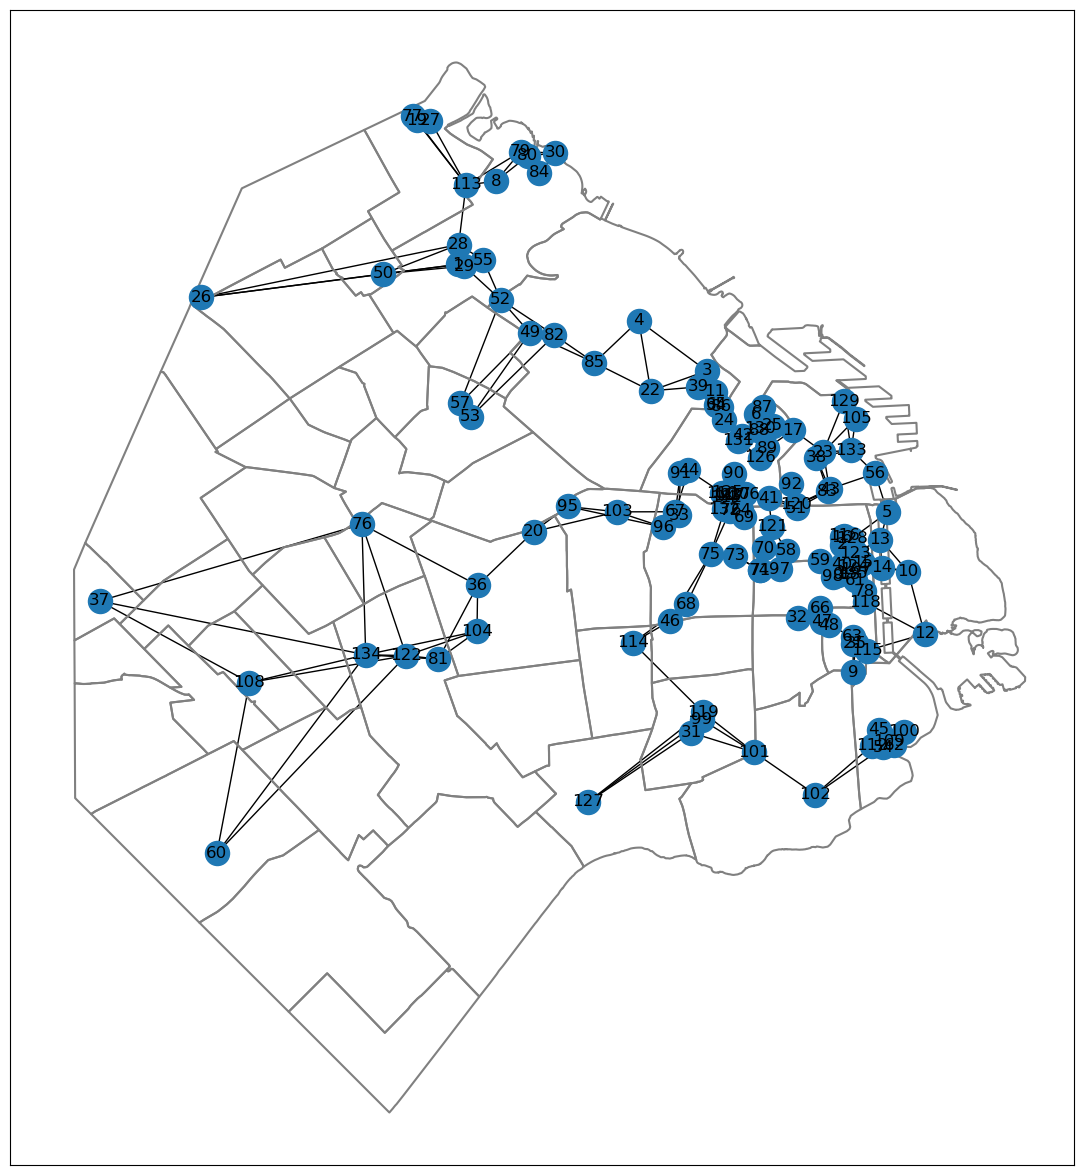

In [7]:
# @title
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

QVQ Mp = b a partir de la ecuacion 3:
$$
\mathbf{p} = (1 - \alpha)\mathbf{C} \mathbf{p} + \frac{\alpha}{N} \mathbf{1}
$$

sabiendo que
$$
\mathbf{M} = \frac{N}{\alpha}(\mathbf{I} - (1 - \alpha)\mathbf{C}), \quad \mathbf{b} = \mathbf{1}
$$

la estrategia consiste en llevar la ecuación 3 a la forma de M. \\
Se reordenan los términos:
$$
\mathbf{p} - (1 - \alpha)\mathbf{C} \mathbf{p} = \frac{\alpha}{N} \mathbf{1}
$$

sacamos p como factor común del lado izquierdo de la ecuación:
$$
(\mathbf{I} - (1 - \alpha)\mathbf{C}) \mathbf{p} = \frac{\alpha}{N} \mathbf{1}
$$

pasamos $ \frac{\alpha}{N} $ al otro lado, que es lo mismo que multiplicar ambos lados por $ \frac{N}{\alpha} $:
$$
\frac{N}{\alpha} (\mathbf{I} - (1 - \alpha)\mathbf{C}) \mathbf{p} = \mathbf{1}
$$
Ahora simplemente reemplazamos por M y b. Así, la forma final queda
$$
\mathbf{M} \mathbf{p} = \mathbf{b}
$$
que es a lo que se quería llegar.

###De que nos sirve esto? Porque ahora al M le puedo calcular LU.


## Punto 2:


El que exista una solución y que sea única depende de que la matriz M sea inversible. Para saber si lo es, tenemos que fijarnos si su determinante es distinto de cero o que su sistema no sea SI o SCI (ambos métodos son equivalentes) \\
Verificamos entonces que M sea inversible:
$$
\mathbf{M} \mathbf{p} = \mathbf{b}
$$

$$
\mathbf{M} = \frac{N}{\alpha} (\mathbf{I} - (1 - \alpha)\mathbf{C})
$$
Sabemos que $\frac{N}{\alpha}$ es un escalar distinto de cero ($N>0$ y $0<{\alpha} < 1$), así que la inversibilidad de $M$ depende exclusivamente de la matriz:
$$
\mathbf{I} - (1 - \alpha)\mathbf{C}
$$
Tomo $\mathbf{C^*} = (1 - \alpha)\mathbf{C}$. Como $\mathbf{C} = A^TK^{-1}$, $A^T$ es cuadrada porque hay N museos y se relacionan entre sí, y $K^{-1}$ también lo es (matriz diagonal de grados), entonces $C^*$ es cuadrada.

Como $C$ es una matriz estocástica por columnas y $(1-\alpha) < 1$ (porque $0 < \alpha < 1$), entonces la norma 1 de $C^*$ es estrictamente menor que 1.

Queremos demostrar (por el absurdo) que $I - C^*$ es inversible.

Llamo $D = I - C^*$ y suponemos que $D$ no es inversible. Entonces existe un vector no nulo $x\neq0$ tal que:

$$Dx = (I - C^*)x = 0 \Rightarrow x = C^*x$$

Aplicamos norma 1 a ambos lados:

$$\|x\|_1 = \|C^*x\|_1 \leq \|C^*\|_1 \cdot \|x\|_1$$

Como $ \|C^*\|_1 < 1 \ $, se tiene:

$$\|x\|_1 \leq \|C^*\|_1 \cdot \|x\|_1
\Rightarrow (1 - \|C^*\|_1)\|x\|_1 \leq 0$$

Pero $ 1 - \|C^*\|_1 > 0 \ $, por lo tanto:

$$(1 - \|C^*\|_1)\|x\|_1 \leq 0 \Rightarrow \|x\|_1 \leq 0$$

Como la norma 1 es siempre no negativa, se deduce que:

$$\|x\|_1 = 0 \Rightarrow x = 0$$

Esto contradice la suposición de que $ x \neq 0 \ $.  

Se llegó a una contradicción, por lo tanto, la suposición de que $ D = I - C^* $ no es inversible es falsa.  
Luego, $ I - C^* $ es inversible.

Por lo tanto, $M$ es inversible, y el sistema tiene una única solución.
$$\mathbf{M} \text{ es inversible} \\
Mp = b \text{ tiene solución única}$$ible} \\
Mp = b \text{ tiene solución única}$$

> VALEN: Por un lado, deberían demostrar que $C$ irreducible $\Longrightarrow I - (1 - \alpha)C$ inversible. Por el otro lado, el grafo representado por C no tiene por qué ser fuertemente conexo, así que todo eso no vale. Si no se les ocurre cómo probar que $M$ es inversible miren la ayuda del campus.✅

## Punto 3:

Index(['id', '@id', 'addr:city', 'addr:housenumber', 'addr:postcode',
       'addr:province', 'addr:street', 'alt_name', 'amenity', 'architect',
       'architect:wikidata', 'architect:wikipedia', 'barrier', 'building',
       'building:levels', 'building:levels:underground', 'charge',
       'construction_date', 'contact:email', 'contact:phone',
       'contact:website', 'description', 'description:en', 'description:es',
       'email', 'email2', 'facebook', 'fee', 'height', 'heritage', 'historic',
       'image', 'instagram', 'internet_access', 'level', 'material',
       'memorial', 'museum', 'museum_type', 'name', 'name:de', 'name:en',
       'name:es', 'name:fr', 'name:he', 'name:nl', 'name:ru', 'name:uk',
       'name:zh', 'note', 'official_name', 'old_name', 'opening_hours',
       'operator', 'operator:type', 'phone', 'postal_code', 'ref', 'religion',
       'roof:material', 'roof:shape', 'ship:type', 'short_name', 'source',
       'start_date', 'toilets:wheelchair', 'tourism',

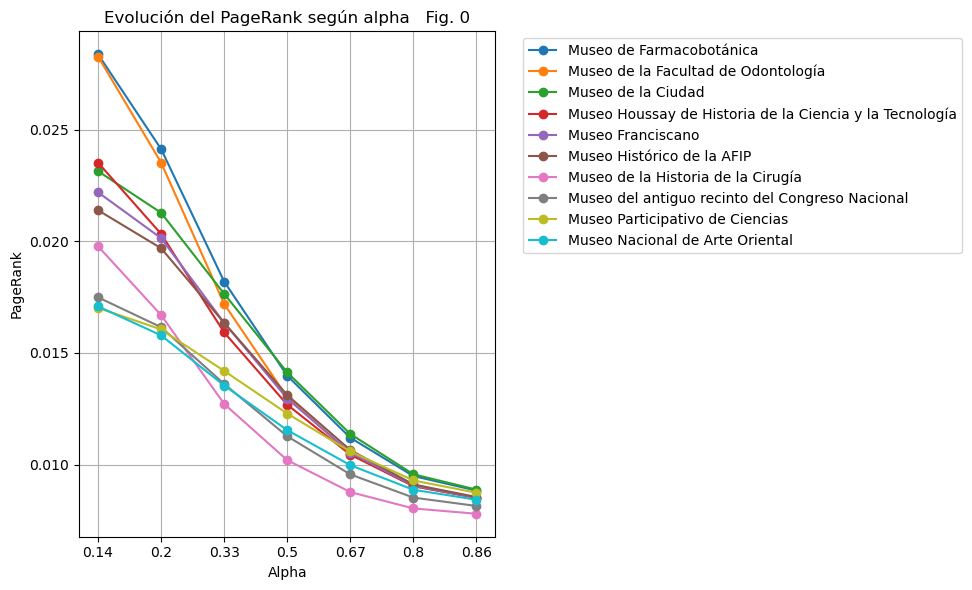

In [8]:
import importlib

A = construye_adyacencia(D, m=3)
print(museos.columns)
nombres_museos = list(museos["name"])

#Elegimos los 10 museos con mayor PR cuando alpha = 1/5

p_inicial = calcula_pagerank(A, alpha=1/5)
top_museos_idx = np.argsort(p_inicial)[-10:][::-1]

#Calculamos PR para distintos valores de alpha

alphas = [1/7, 1/5, 1/3, 1/2, 2/3, 4/5, 6/7]
pageranks_por_alpha = {alpha: calcula_pagerank(A, alpha) for alpha in alphas}

# ---Graficamos la evolución del PR para los 10 museos seleccionados ---

plt.figure(figsize=(10, 6))

for idx in top_museos_idx:
    valores = [pageranks_por_alpha[alpha][idx] for alpha in alphas]
    plt.plot(
        [str(round(a, 2)) for a in alphas],
        valores,
        marker='o',
        label=nombres_museos[idx]
    )

plt.title("Evolución del PageRank según alpha   Fig. 0")
plt.xlabel("Alpha")
plt.ylabel("PageRank")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

> VALEN: Usen los nombres de los museos✅

Con un alpha grande, el usuario salta más aleatoreamiente, establizando asi el ranking. Con un alpha pequeño, los saltos son mas predecibles, el usuario sigue la estructura presupuesta en A. Ergo, los nodos bien conectados llevan la delantera (usualmente los centricos, pero eso lo veremos mas tarde).

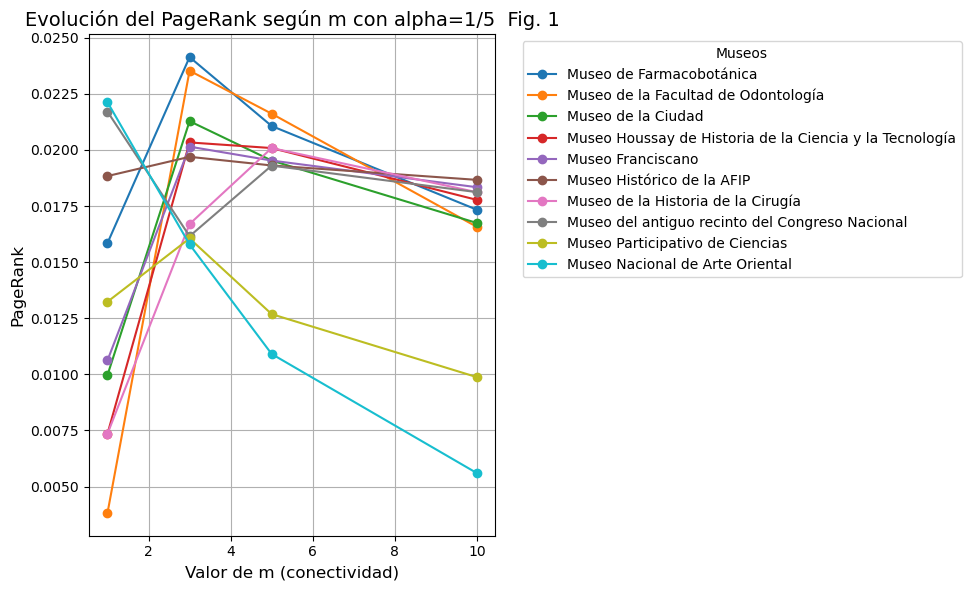

In [9]:
# @title
import matplotlib.pyplot as plt

# Valores de m a comparar
valores_m = [1, 3, 5, 10]
alpha = 1/5

# Almacenar los resultados de PR para cada m
pageranks_por_m = {}
for m in valores_m:
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alpha)
    pageranks_por_m[m] = p

# Elegimos top 10 museos según m=3 como referencia
p_base = pageranks_por_m[3]
top_museos = np.argsort(p_base)[-10:][::-1]

# Graficamos evolución del PR por m
plt.figure(figsize=(10, 6))
for idx in top_museos:
    valores = [pageranks_por_m[m][idx] for m in valores_m]
    plt.plot(valores_m, valores, marker='o', label=nombres_museos[idx])

plt.title("Evolución del PageRank según m con alpha=1/5  Fig. 1", fontsize=14)
plt.xlabel("Valor de m (conectividad)", fontsize=12)
plt.ylabel("PageRank", fontsize=12)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Museos")
plt.tight_layout()
plt.show()

> VALEN: Usen los nombres de los museos✅

Que estamos viendo (Fig. 1)?
m es la cantidad de nodos cercanos (museos mas cercanos) a los que yo conecto un nodo (museo) . Ergo, si yo aumento el m, es logico que haya mas visitas que se consideren conectadas. Es decir, con un m mas chico veremos redes mas dispersas y rankings mas extremos. Con un m mas grande tenemos mas conexiones, mas suavidad y rankings menos dispares. Claramente las posiciones en el ranking son sumamente cambiantes a medida q cambia el m. Notemos por ejemplo el museo 125 que cuando el M = 1 estan posicionados muy bajo...sin embargo al aumentar el M a 3 su posicion pasa a ser 2da.
> VALEN: "... al aumentar el M a ~~2~~ 3 su posición ..."✅

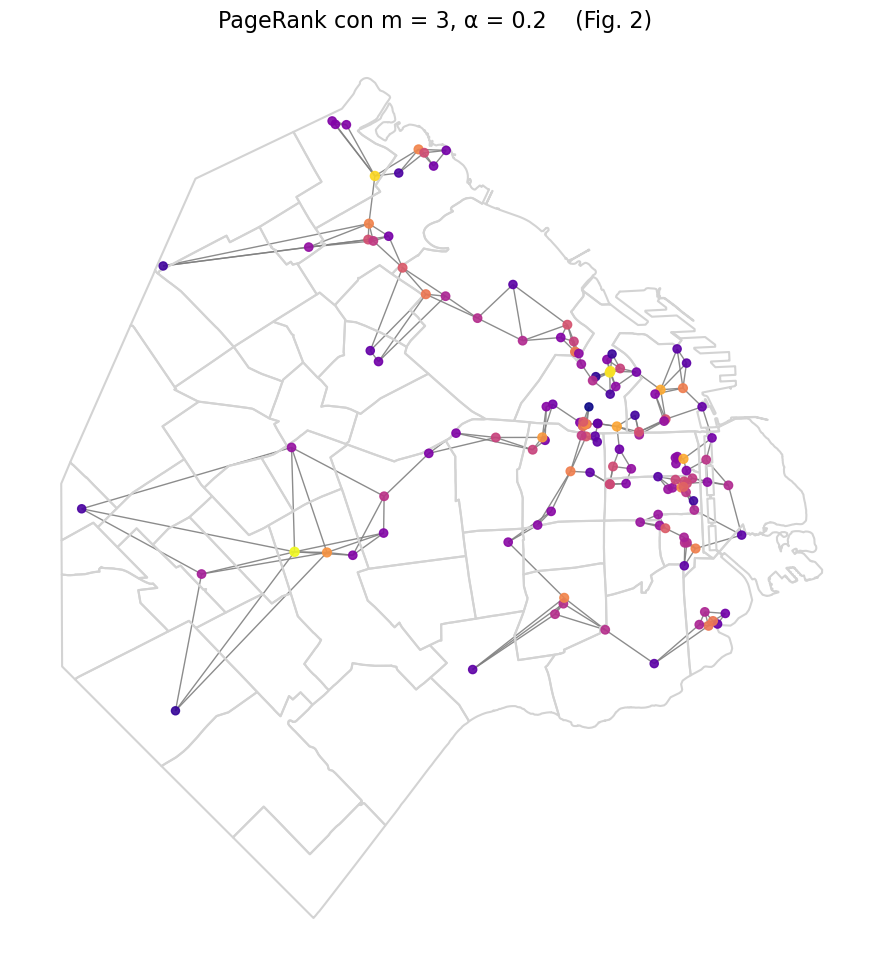

In [10]:
# @title
m = 3
alpha = 0.2

# Coordenadas geográficas
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (coords["x"].iloc[i], coords["y"].iloc[i]) for i in range(len(coords))}


# Construcción de la matriz de adyacencia y grafo
A = construye_adyacencia(D, m)
G = nx.from_numpy_array(A)

# PageRank
pr = nx.pagerank(G, alpha=alpha)
sizes = [5000 * pr[i] for i in G.nodes]

# Visualización
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f"PageRank con m = {m}, α = {alpha}    (Fig. 2)", fontsize=16)

barrios.to_crs("EPSG:22184").boundary.plot(color='lightgray', ax=ax)

nx.draw_networkx(
    G, pos=G_layout, ax=ax,
    node_size=sizes,
    node_color=list(pr.values()),
    cmap=plt.cm.plasma,
    edge_color='gray',
    with_labels=False,
    alpha=0.9
)

plt.axis('off')
plt.show()


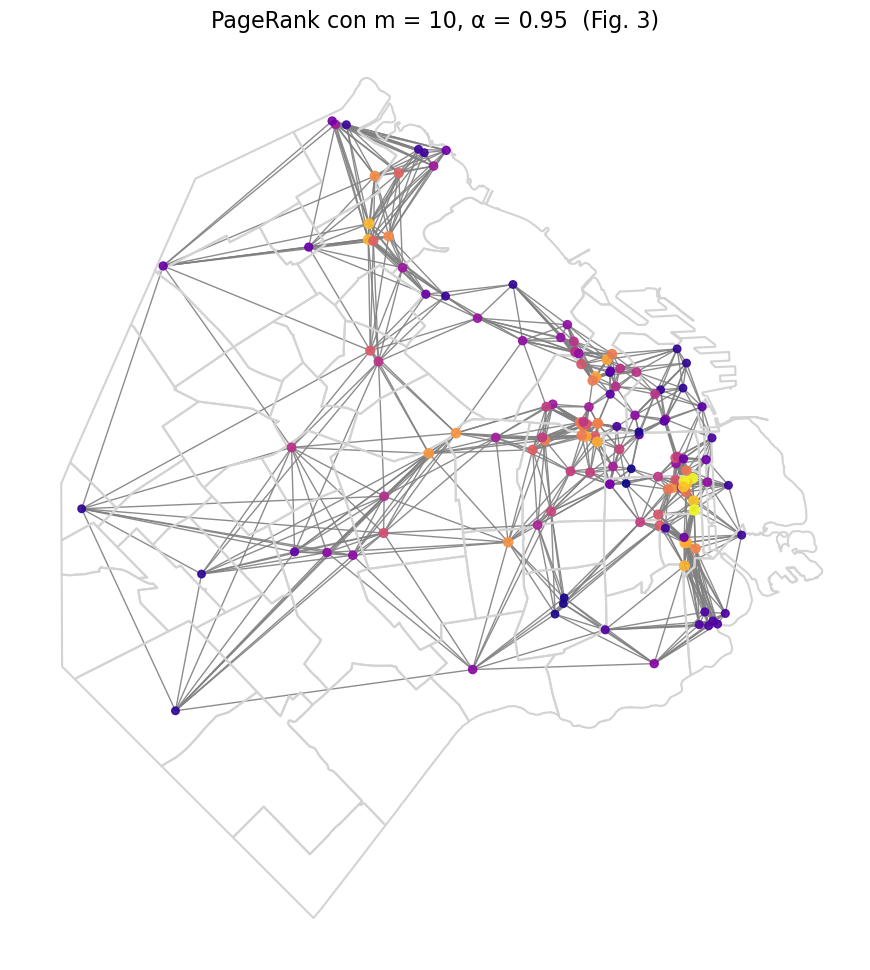

In [11]:
# @title
m = 10
alpha = 0.95

# Coordenadas geográficas
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (coords["x"].iloc[i], coords["y"].iloc[i]) for i in range(len(coords))}


    # Construcción de la matriz de adyacencia y grafo
A = construye_adyacencia(D, m)
G = nx.from_numpy_array(A)

# PageRank
pr = nx.pagerank(G, alpha=alpha)
sizes = [5000 * pr[i] for i in G.nodes]

# Visualización
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f"PageRank con m = {m}, α = {alpha}  (Fig. 3)", fontsize=16)

barrios.to_crs("EPSG:22184").boundary.plot(color='lightgray', ax=ax)

nx.draw_networkx(
    G, pos=G_layout, ax=ax,
    node_size=sizes,
    node_color=list(pr.values()),
    cmap=plt.cm.plasma,
    edge_color='gray',
    with_labels=False,
    alpha=0.9
)

plt.axis('off')
plt.show()


A que debemos prestar atencion acá? Como dijimos anteriormente, alpha es el factor de contemplación de saltos aleatorios, es decir, que si yo disminuyo el alpha tendremos mas aleatoreidad y como resultado nodos con tamaños parejos y poco destacados, como el el segundo mapa (Fig. 3). En cambio, en el primer mapa (Fig. 2), notamos que hay nodos mas destacados (Los mas grandes, usualmente ubicados en el centro y no en las periferias) que otros ya que se considera muy poca aleatoreidad al tener un alpha alto.

El otro valor que variamos entre los dos mapas es el m. Ya explicamos que cuando yo auento el valor de m, estoy "tolerando" conexiones mas distantes. Como consecuencia, la diferencia entre ambos mapas es clara. Con un m mas grande (Fig 3.) las conexiones son muchas mas, entre museos muchos museos y muy distantes que con un m mas chico (Fig. 2).

Para finalmente responder las preguntas, al aumentar alpha, las zonas centricas se hacen mas importantes y con nodos mas destacados.

Con el m pasa el proceso inverso. Al disminuir el m, las zonas centricas son mas importantes, pero cuando lo aumento, los museos mas distantes empiezan a ser mas "tolerados" y tienen un numero mas parecido de conexiones que los centrales estabilizando el pagerank a un lugar comun.

> VALEN: Esta explicación es al revés de lo que pasa de verdad y también al revés de lo que dijeron más arriba! ✅ (abajo corrección)

> VALEN: Por otro lado, faltan bastante mapas acá. La consigna pedía que hagan los mapas para todos los casos que probaron en el b y c. Hagan un gráfico con los 4 mapas para $m$ (con $\alpha$ fijo) y otro con los 7 mapas para $\alpha$ (con $m$ fijo). Eso también les va a ayudar a entender mejor lo que ocurre (aunque lo que dijeron más arriba ya estaba bastante bien) y va a mostrar mucho mejor la variación. ✅ (abajo)

# CORRECCIÓN punto 3

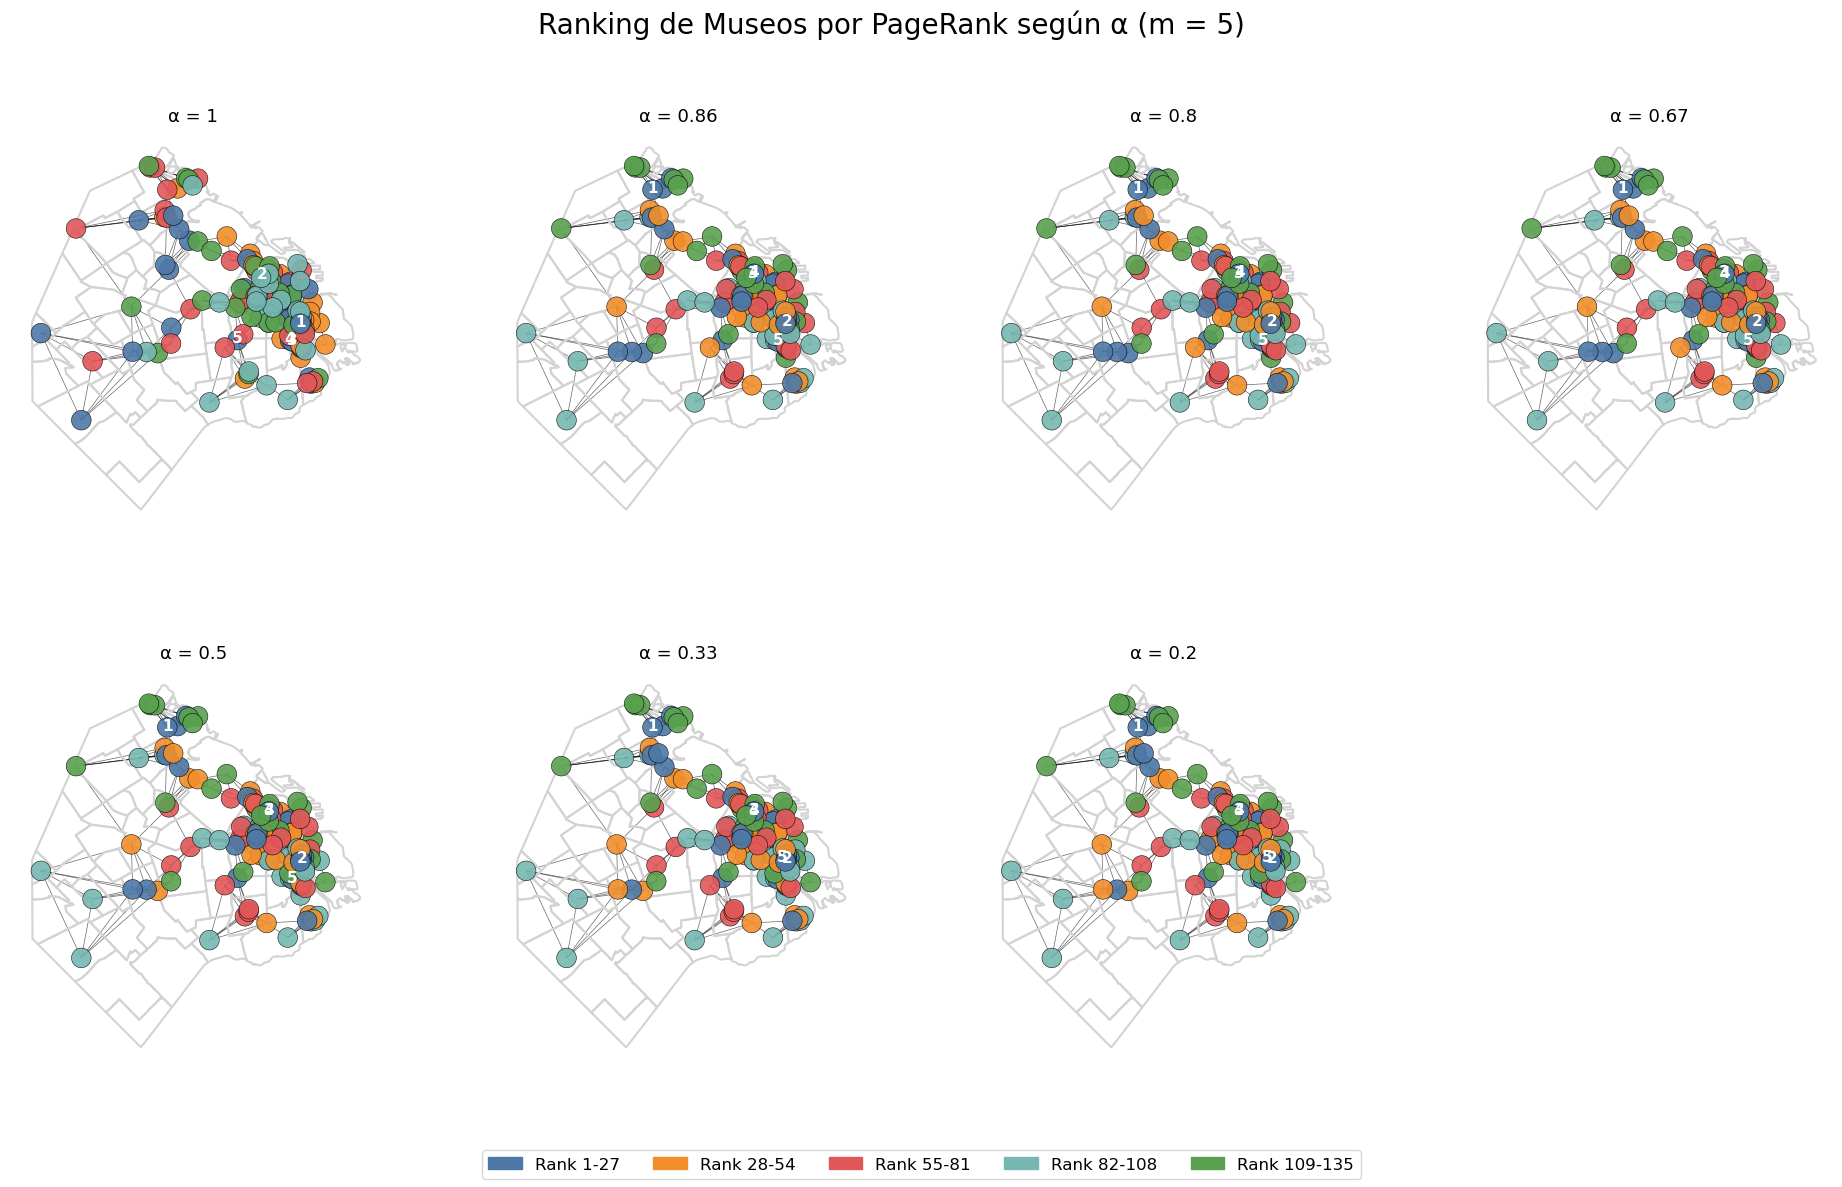

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.patches as mpatches

# === Parámetros ===
m = 5
valores_alpha = [1, 6/7, 0.8, 0.67, 0.5, 0.33, 0.2]
node_size = 200
Nprincipales = 5
color_list = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F"]
quintiles = len(color_list)

# === Preparar red y layout ===
A = construye_adyacencia(D, m)
A = np.ceil((A + A.T) / 2)
G = nx.from_numpy_array(A)

coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (coords["x"].iloc[i], coords["y"].iloc[i]) for i in range(len(coords))}

# === PageRank para cada alpha ===
prs = [calcula_pagerank(A, alpha) for alpha in valores_alpha]

# === Figura ===
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

for ax, alpha, pr in zip(axes, valores_alpha, prs):
    ranked_idxs = np.argsort(pr)[::-1]
    rank_positions = {idx: rank + 1 for rank, idx in enumerate(ranked_idxs)}
    N = len(pr)

    # Colores por quintil
    colors = []
    for i in range(N):
        rank = rank_positions[i]
        bin_index = min((rank - 1) * quintiles // N, quintiles - 1)
        colors.append(color_list[bin_index])

    # Etiquetas Top 3
    top_idxs = ranked_idxs[:Nprincipales]
    labels = {idx: str(i + 1) for i, idx in enumerate(top_idxs)}
    pos_labels = {idx: (G_layout[idx][0], G_layout[idx][1] + 100) for idx in top_idxs}

    # Dibujar red
    barrios.to_crs("EPSG:22184").boundary.plot(color='lightgray', ax=ax)
    nx.draw_networkx_edges(G, G_layout, ax=ax, edge_color='black', alpha=0.6, width=0.5)
    nx.draw_networkx_nodes(G, G_layout, ax=ax,
                           node_size=node_size,
                           node_color=colors,
                           edgecolors='black',
                           linewidths=0.4,
                           alpha=0.9)
    nx.draw_networkx_labels(G, pos_labels, labels=labels,
                            font_size=11, font_color='white', font_weight='bold', ax=ax)

    ax.set_title(f"α = {round(alpha, 2)}", fontsize=13)
    ax.axis('off')

# Limpiar subplots vacíos
for i in range(len(valores_alpha), len(axes)):
    fig.delaxes(axes[i])

# === Leyenda ===
rango_por_color = len(prs[0]) // quintiles
legend_labels = [f"{i * rango_por_color + 1}-{(i + 1) * rango_por_color}" for i in range(quintiles)]
handles = [mpatches.Patch(color=color_list[i], label=f"Rank {legend_labels[i]}") for i in range(quintiles)]

fig.legend(handles=handles, loc='lower center', ncol=quintiles, fontsize=12)

# === Título y layout ===
plt.subplots_adjust(top=0.88, bottom=0.1, hspace=0.35)
fig.suptitle(f"Ranking de Museos por PageRank según α (m = {m})", fontsize=20)
plt.show()


Con un alpha grande, el usuario salta más aleatoriamente, establizando asi el ranking (los puntos de los perifericos y los centricos son casi iguales). Con un alpha pequeño, los saltos son mas predecibles, el usuario sigue la estructura presupuesta en A. Ergo, los nodos bien conectados llevan la delantera (los centricos claramente mas grandes que los perifericos).


> VALEN: Todos los mapas son iguales! Si hay alguna diferencia es absolutamente microscópica y no se ve. Fíjense que no haya algún bug en el código con el que los hicieron. En la explicación de acá abajo parece que si que tenían los mapas bien así que capaz pasó algo en el medio.✅ capaz ahi se ve mas? me ta costando este. Con tamaños no pude hacer que se diferencien y quedaba feo. Esta division de colores/rango ranking me parecio mas clara. Como veras intente escandalizar las diferencias de alpha buscando alguna division mas clara...sin un exito rotundo. Pero se puede ver con el alpha 1 lo random que termina siendo el top 5 y la distribucion general del pagerank. Muchos azules en las periferias. A medida que achico alpha, los azules logicamente se centralizan 

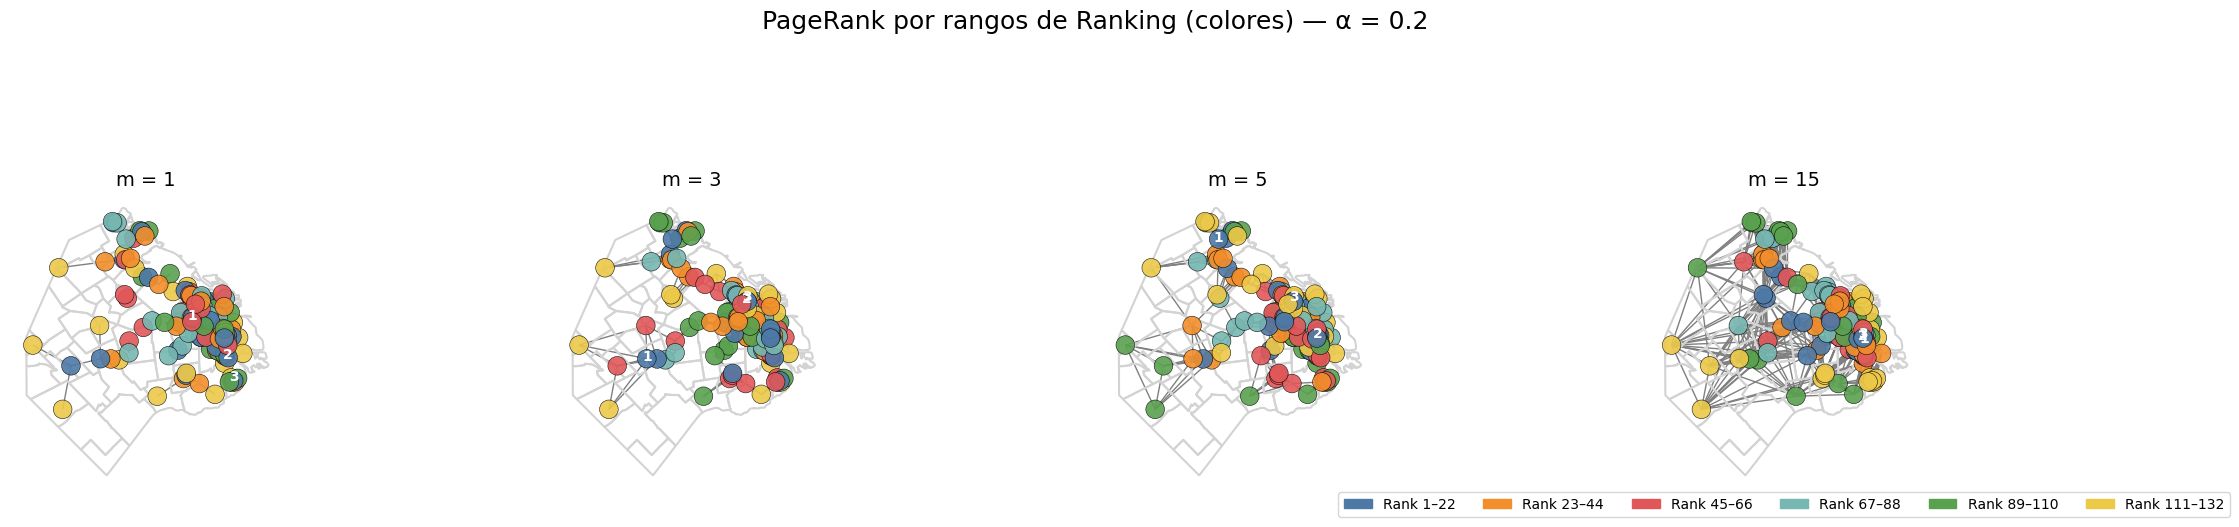

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.patches as mpatches


valores_m = [1, 3, 5, 15]
alpha = 0.2
Nprincipales = 3
node_size = 180
color_list = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F", "#EDC948"]  # 6 colores


coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (coords["x"].iloc[i], coords["y"].iloc[i]) for i in range(len(coords))}


fig, axes = plt.subplots(1, len(valores_m), figsize=(22, 6))
axes = axes.flatten()

for ax, m in zip(axes, valores_m):
    A = construye_adyacencia(D, m)
    A = np.ceil((A + A.T) / 2)
    G = nx.from_numpy_array(A)
    pr = calcula_pagerank(A, alpha)
    pr = pr / pr.sum()

    ranked_idxs = np.argsort(pr)[::-1]
    rank_positions = {idx: rank + 1 for rank, idx in enumerate(ranked_idxs)}

    N = len(pr)
    colors = []
    for i in range(N):
        rank = rank_positions[i]
        bin_index = min((rank - 1) * 6 // N, 5)
        colors.append(color_list[bin_index])

    top_n = min(Nprincipales, len(ranked_idxs))
    top_idxs = ranked_idxs[:top_n]
    labels = {idx: str(i + 1) for i, idx in enumerate(top_idxs)}
    pos_labels = {}
    for i, idx in enumerate(top_idxs):
        x, y = G_layout[idx]
        pos_labels[idx] = (x, y + (i + 1) * 100)  # desplazamiento progresivo

    barrios.to_crs("EPSG:22184").boundary.plot(color='lightgray', ax=ax)
    nx.draw_networkx_edges(G, G_layout, ax=ax, edge_color='gray', alpha=1)
    nx.draw_networkx_nodes(G, G_layout, ax=ax,
                           node_size=node_size,
                           node_color=colors,
                           edgecolors='black',
                           linewidths=0.4,
                           alpha=0.9)
    nx.draw_networkx_labels(G, pos_labels, labels=labels,
                            font_size=10, font_color='white', font_weight='bold', ax=ax)

    ax.set_title(f"m = {m}", fontsize=14)
    ax.axis('off')

# Leyenda
patches = [
    mpatches.Patch(color=color_list[0], label="Rank 1–22"),
    mpatches.Patch(color=color_list[1], label="Rank 23–44"),
    mpatches.Patch(color=color_list[2], label="Rank 45–66"),
    mpatches.Patch(color=color_list[3], label="Rank 67–88"),
    mpatches.Patch(color=color_list[4], label="Rank 89–110"),
    mpatches.Patch(color=color_list[5], label="Rank 111–132"),
]
plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=6)

plt.suptitle(f"PageRank por rangos de Ranking (colores) — α = {alpha}", fontsize=18, y=1.03)
plt.tight_layout()
plt.show()


A medida que aumenta el valor de (m), cada museo se conecta con más vecinos cercanos (tolera mas vecinos y mas lejanos), haciendo que la red sea más densa. Esto permite que museos que inicialmente eran periféricos (con pocas conexiones) ganen relevancia, al estar mejor conectados.

> VALEN: Eso no es cierto pero cuesta darse cuenta porque esos mapas son difíciles de entender. No queda claro que representa cada color de la paleta de colores y son bastante chiquitos los puntos. Yo recomendaría quedarse con un solo color e ir variando el tamaño de los puntos dependiendo de su pagerank. Lo mismo aplica a los mapas de $\alpha$.✅Ahi va mejor? Por lo que se ve al aumentar m, mi top 3 del ranking sale de las periferias y se mueve mas hacia el centro, dandonos a enteder que la relacion seria que al aumentar el m, los nodos centrales cobran mayor importancia y los perifericos la pierden. Si miramos los colores, notamos que con m=1 tenemos azules de rankings altos (1 al 22) en las periferias con m=1, cosa que no sucede con m = 15 donde todos los azules quedan concentrados en el centro y las periferias muy amarillas y verdes(rankigs muy bajos de entre 90 y mas.)

## Punto 4:

> VALEN: Cuidado con el formato, lo de abajo se ve bien en colab pero se rompe en vscode (no hace falta que lo arreglen pero estaría bueno) (me agarre a piñas con esto y no logro q renderize en ambos, lo dejamo asi q lo viejo funciona, valen)

El enunciado ya nos define B como: $$
B = \sum_{k=0}^{r-1} C^k
$$

Luego, por cada paso, y suponiendo que cada visitante ejecuta r visitas:
$$
Paso(0): C^0 * v = I * v = v
$$
$$
Paso (1): C^1 * v = C * v
$$
$$
Paso (2): C^2 * v
$$
$$
Paso {(r-1)}: C^{(r-1)} * {v}
$$

> VALEN: Explicar por qué cada paso es así✅(abajo)

Luego,
$$
w = \sum_{k=0}^{r-1} C^k * v = B * v
$$
pasando del otro lado...

RTA:
v = B^-1 * w  

## ¿Por qué cada paso corresponde a C^k v ?

La matriz \( C \) es una matriz de transición: \( C_{ij} \) representa la probabilidad de que una persona pase del museo \( j \) al museo \( i \) en un solo paso.

Si \( v \) es el vector que contiene la cantidad de visitantes que comenzaron su recorrido en cada museo (paso 0), entonces:

- Paso 0: \( v \)
- Paso 1: \( C v \)
- Paso 2: \( C^2 v \)
- …
- Paso \( k \): \( C^k v \)

Cada multiplicación por \( C \) representa una transición: aplicar \( C \) una vez da las visitas al paso 1, aplicarlo dos veces da las visitas en el paso 2, y así sucesivamente.

Esto, ahora que vimos una cadena de Markov, \( C^k v \) representa la distribución de estados (en este caso, museos visitados) después de \( k \) pasos, partiendo de la distribución inicial \( v \).

Por lo tanto, si cada persona realiza exactamente \( r \) visitas, el total de visitas acumuladas será:

$$
w = v + C v + C^2 v + \cdots + C^{r-1} v = \left( \sum_{k=0}^{r-1} C^k \right) v = Bv
$$

y entonces:

$$
B = \sum_{k=0}^{r-1} C^k
$$

es la matriz que relaciona el total de visitas con las primeras visitas.


## Punto 5:
Calcula b:
Queremos estimar cuántas personas empezaron su recorrido en cada museo (vector V)

Pero solo sabemos cuántas visitas recibió cada museo en total (vector W, archivo visitas en notas).

Entonces, el problema es:

Si cada persona visita r museos en total, y sabemos cuántas visitas tuvo cada museo (w), ¿podemos saber de dónde arrancó cada persona (v)?

V = B^(−1) * w

con $$
B = \sum_{k=0}^{r-1} C^k
$$ya que cada paso se modela con la matriz de trancision C, que recordemos, nos dice la probabilidad de ir de un museo a otro

> VALEN: Otra vez cuidado con el formato acá

Ahora que ya tenemos B, podemos hacer v = b^-1 * w (visitas(.txt) totales) para saber cuantas personas empezaron en cada museo

In [15]:
w = pd.read_csv("./visitas.txt", header=None)
r=3
C=calcula_matriz_C_continua(D)  #Calculamos
B=calcula_B(C, r)

#Ax=b
#Bv=w

#Ly=w
#Uv=y

L,U=calculaLU(B)
y=scipy.linalg.solve_triangular(L,w,lower=True)
v=scipy.linalg.solve_triangular(U,y)

cantidad_total_de_visitantes=scipy.linalg.norm(v,ord=1)


print(f"La cantidad total de visitantes (corregida) es: {cantidad_total_de_visitantes.round()}")
#

La cantidad total de visitantes (corregida) es: 136605.0


> VALEN: Esto está mal por el error en `calcula_matriz_C_continua`, revisen
> ✅

## Punto 6:

Ahora suponemos que el vector w (visitas de cada museo en total) tiene un error del 5% (o 0,05). Queremos calcular la condicion1 de B para saber:
Si el sistema es estable (condicion chica, cerca del 1, con errores en w que afectan menos al v)
> VALEN: No es que el error no afecta a $v$, solo lo afecta menos ✅

Si el sistema es inestable (numero condicion grande que arruina la estimacion de v)

Luego, sabemos que $$
\frac{||\mathbf{w} - \tilde{\mathbf{w}}||_1}{||\mathbf{w}||_1}==0,05
$$

ergo,
$$
\frac{||\mathbf{v} - \tilde{\mathbf{v}}||_1}{||\mathbf{v}||_1}
\leq
\text{cond}_1(B) \cdot 0,05
$$

calculemos el numero de condicion1:
$$
\text{cond}_1(B) = \|B\|_1 \cdot \|B^{-1}\|_1
$$

> VALEN: Formato

In [16]:
def condicion_1(B):
   n = B.shape[0]
   I = np.eye(n)
   L, U = calculaLU(B)
   B_inv = np.zeros_like(B)
   for i in range(n): #invertimos B haciendo B*x = I
        e = I[:, i]  # tomamos la columna i de la identidad
        y = scipy.linalg.solve_triangular(L, e, lower=True)  # resolvemos Ly = e
        x = scipy.linalg.solve_triangular(U, y)              # resolvemos Ux = y
        B_inv[:, i] = x  # guardamos la columna i de la inversa
   norm_B = np.abs(B).sum(axis=0).max() #hacemos norma 1 de B (columnas)
   norm_B_inv = np.abs(B_inv).sum(axis=0).max() #hacemos norma 1 de B^-1
   cond_1 = norm_B * norm_B_inv #cond1(B) = norm1(B) * norm1(B^-1)
   return cond_1

In [17]:
print(condicion_1(B))
print(np.linalg.cond(B, p=1))
print("Como podemos ver el resultado (corregido) es practicamente equivalente")

5.051771176665007
5.051771176665004
Como podemos ver el resultado (corregido) es practicamente equivalente


El numero de condicion es bastante grande, por lo q podemos concluir que el sistema es inestable. 5.05 * 0,05 = 0,2525

siendo entonces 0,2525 la cota superior de v del error relativo de estimacion de v. Luego, tenemos un 25,25% de error en la estimacion (corregida). Llamemoslo un sistema medianamente sensible a los errores de entrada.

> VALEN: Esto está mal por el error en `calcula_matriz_C_continua`, revisen
> ✅


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, '7'),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19

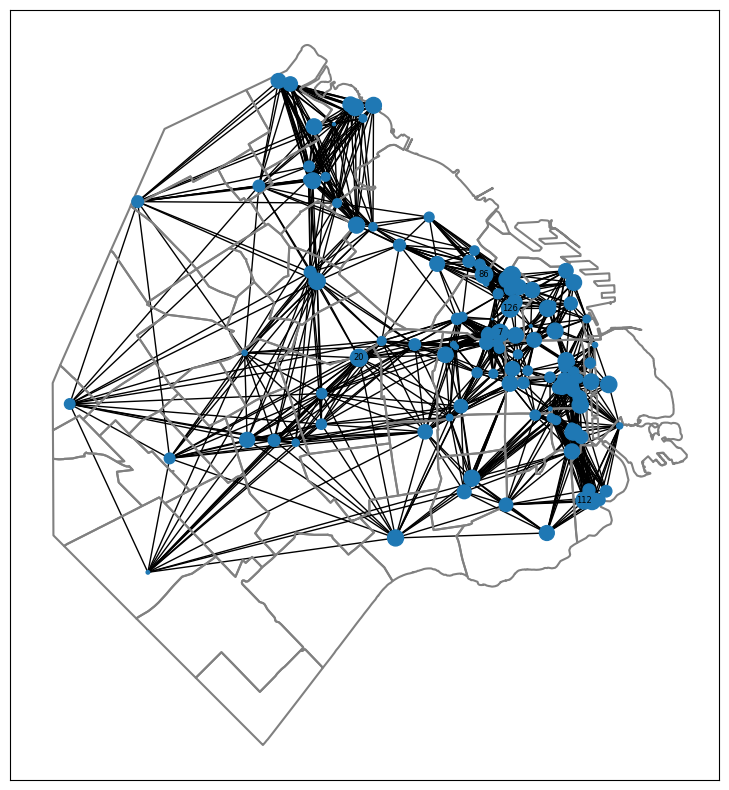

In [18]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres
#aca los profes lo armaron con numero de pagerank. jugamos con eso en vez de tamaños de circulos? porque no estoy logrando una buena visualizacion. quisas reducionedo el numero de museos usados y jugando con esto nos va mejor

# TP PARTE 2

## Punto 1

Muestren que el vector de unos 1 es autovector de las matrices R y L. ¿Que
autovalor tiene? ¿Y que agrupacion de la red representa?

In [19]:
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])


# Vector de unos
v_1 = np.ones((A.shape[0], 1))

# Laplaciana: L = K - A
K = np.diag(A.sum(axis=1))
L = K - A

# Matriz de probabilidad esperada para R
E = A.sum() / 2
P = np.outer(A.sum(axis=1), A.sum(axis=1)) / (2 * E)
R = A - P

L1 = L @ v_1
R1 = R @ v_1
tol = 1e-10  # tolerancia

# Verificamos si son aproximadamente ceros
es_casi_cero_L = np.all(np.abs(L1) < tol)
es_casi_cero_R = np.all(np.abs(R1) < tol)

print("L * 1 ≈ 0:", es_casi_cero_L)
print("R * 1 ≈ 0:", es_casi_cero_R)

L * 1 ≈ 0: True
R * 1 ≈ 0: True


### ¿Por qué el vector de unos es autovector de L y R?

#### Laplaciana: $$L = K - A$$

Multiplicamos $$L \cdot \mathbf{1}$$

$$K \cdot \mathbf{1}$$ da el vector de grados
$$A \cdot \mathbf{1}$$ también da el vector de grados

> VALEN: Lo de que $A1$ da el vector de grados tienen que mostrarlo.✅:
############correccion/agregado#####################
###Por qué $ A \cdot \mathbf{1}$ da el vector de grados?

Sea $ A \in \mathbb{R}^{n \times n}$ la matriz de adyacencia de un grafo no dirigido. El elemento $ a_{ij} $ indica si hay una arista entre el nodo \( i \) y el nodo \( j \) (es decir, toma valor 1 si están conectados, 0 si no).

Multiplicamos \( A \) por el vector de unos:

$$
(A \cdot \mathbf{1})_i = \sum_{j=1}^n a_{ij}
$$

Esta suma recorre la fila \( i \) de la matriz \( A \), contando la cantidad de unos (o sea, las conexiones del nodo \( i \)).

Por definición, esto es exactamente el **grado del nodo \( i \)**.

Entonces:
$$
A \cdot \mathbf{1} =
\begin{bmatrix}
\text{grado del nodo 1} \\
\text{grado del nodo 2} \\
\vdots \\
\text{grado del nodo } n
\end{bmatrix}
= \mathbf{k}
$$

**Conclusión:**  
Multiplicar la matriz de adyacencia \( A \) por el vector de unos $ \mathbf{1} $ da como resultado el **vector de grados** del grafo.

Por ejemplo si A:
$$
A =
\begin{bmatrix}
0 & 1 & 1 & 0 \\
1 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}
$$


$$
A \cdot \mathbf{1} =
\begin{bmatrix}
0+1+1+0 \\
1+0+0+1 \\
1+0+0+0 \\
0+1+0+0 \\
\end{bmatrix}
=
\begin{bmatrix}
2 \\
2 \\
1 \\
1 \\
\end{bmatrix}
$$

que es el vector de grados justamente ( que contiene, en cada componente i, el grado del nodo i ,es decir, cuántas conexiones/aristas tiene ese nodo.)
####################################################

Entonces:

$$
L \cdot \mathbf{1} = K \cdot \mathbf{1} - A \cdot \mathbf{1} = 0
$$

El vector de unos es autovector de $L$ con autovalor **0**.
---

#### Matriz de modularidad: $$R = A - P$$

Multiplicamos $$R \cdot \mathbf{1}$$

$$A \cdot \mathbf{1}$$ da el vector de grados
$$P \cdot \mathbf{1}$$ también

> VALEN: Lo de que $P1$ da el vector de grados tienen que mostrarlo.✅->

############correccion/agregado#####################

Recordemos que la matriz de modularidad es:

$$
R = A - P
\quad \text{donde} \quad
P = \frac{k k^T}{2m}
$$

donde:

- $ k $ es el **vector de grados** del grafo
- $ 2m = \sum k_i $ es el **doble del número total de aristas** en el grafo (q es la norma 1 verdad?)

Multiplicamos $ P \cdot \mathbf{1} $:

$$
P \cdot \mathbf{1} =
\left( \frac{k k^T}{2m} \right) \cdot \mathbf{1}
= \frac{k (k^T \cdot \mathbf{1})}{2m}
$$

¿Cuánto vale $ k^T \cdot \mathbf{1} $ ?

$$
k^T \cdot \mathbf{1} = \sum_{i=1}^n k_i = 2m
$$
Reemplazando:

$$
P \cdot \mathbf{1} = \frac{k \cdot 2m}{2m} = k
$$
Conclusión:
$$
P \cdot \mathbf{1} = \mathbf{k}
$$
La matriz $ P $ representa las **conexiones esperadas al azar** si los grados se mantienen constantes pero los enlaces se distribuyen aleatoriamente

Multiplicarla por el vector de unos suma las “probabilidades esperaibles” de conexión de cada nodo, lo cual, por construcción del modelo, nos da nuevamente el **vector de grados** $ \mathbf{k} $.

####################################################

Entonces:

$$
R \cdot \mathbf{1} = A \cdot \mathbf{1} - P \cdot \mathbf{1} = 0
$$

El vector de unos es autovector de $R$ con autovalor **0**.

---

### Interpretación:

El vector $\mathbf{1}$ representa una partición trivial: todos los nodos en el mismo grupo.  
Por eso se asocia al autovalor 0. No sirve para dividir la red.
En
R: todo está como “esperado al azar”
y en L: no hay diferencia entre nodos

> VALEN: Hay algunos errores de latex.

## Punto 1.b

### Teorema:

Si una matriz $$M$$ es simétrica, entonces sus autovectores asociados a autovalores distintos son ortogonales.

---

### Demostración:

Sean u y v autovectores de M, con autovalores $\lambda$ y $\mu$:

$$M u = \lambda u$$  
$$M v = \mu v$$

Multiplicamos escalarmente ambos lados:

1. $$u^T (M v) = u^T (\mu v) = \mu (u^T v)$$  
2. $$u^T (M v) = (M u)^T v = (\lambda u)^T v = \lambda (u^T v)$$

Como $M$ es simétrica, ambas expresiones son iguales:

$$
\lambda (u^T v) = \mu (u^T v)
$$

Entonces:

$$
(\lambda - \mu)(u^T v) = 0
$$

Y si $$\lambda \ne \mu$$ entonces:

$$
u^T v = 0
$$

Es decir: **son ortogonales**.

---

### Aplicación al vector de unos:

Del punto 1.a sabemos que el vector de unos $\mathbf{1}$ es autovector de $L$ y $R$ con autovalor 0.  
Entonces, cualquier autovector con autovalor distinto de 0 será ortogonal a $\mathbf{1}$:

$$
v^T \cdot \mathbf{1} = 0
$$

---

Esto significa que los autovectores utiles para dividir la red tienen componentes positivas y negativas que se compensan, y por eso **pueden separar la red en dos grupos distintos**.


## Punto 1.c

### Queremos demostrar:

Todo autovector asociado a un autovalor distinto de 0 cumple:

$$
\sum_i v_i = 0
$$

---

### Demostración:

Del punto 1.b sabemos que:

- Si $v$ es autovector de $L$ o $R$ con autovalor distinto de 0
- Entonces es ortogonal al vector de unos $\mathbf{1}$

Es decir:

$$
v^T \cdot \mathbf{1} = 0
$$

Pero:

$$
v^T \cdot \mathbf{1} = \sum_i v_i
$$

Entonces:

$$
\sum_i v_i = 0
$$

---

Esto significa que los autovectores útiles para particionar la red tienen una parte positiva y otra negativa que se compensan.  
Eso permite usar el signo de cada componente para separar en dos grupos.


#Punto 2: Metodo potencia

## Punto 2.a — Shifting de autovalores

### Queremos demostrar:

Si $$ M \mathbf{v}_i = \lambda_i \mathbf{v}_i $$ entonces:

$$
(M + \mu I) \mathbf{v}_i = (\lambda_i + \mu) \mathbf{v}_i
$$

Y que si $$ \lambda_i + \mu \ne 0 $$ para todo $i$, entonces $ M + \mu I $ es invertible.

---

### Demostración:

Sabemos que:

$$
M \mathbf{v}_i = \lambda_i \mathbf{v}_i
$$

Entonces:

$$
(M + \mu I)\mathbf{v}_i = M \mathbf{v}_i + \mu I \mathbf{v}_i
= \lambda_i \mathbf{v}_i + \mu \mathbf{v}_i
= (\lambda_i + \mu) \mathbf{v}_i
$$

---

- Los autovectores no cambian: siguen siendo $ \mathbf{v}_i $
- Los autovalores se trasladan: $ \lambda_i \rightarrow \lambda_i + \mu $
- Si $ \lambda_i + \mu \ne 0 $ para todo $ i $, entonces $ M + \mu I $ **es invertible**


##Punto 2.b

In [20]:
from numpy.linalg import norm, solve

# Matriz de adyacencia
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])

# Construimos la Laplaciana L = K - A
K = np.diag(A.sum(axis=1))
L = K - A

# Aplicamos shifting para evitar singularidad
mu = 0.1
L_mu = L + mu * np.eye(L.shape[0])

# Inicializamos un vector aleatorio normalizado
np.random.seed(42)
x = np.random.rand(L.shape[0])
x = x / norm(x)

# Método de la potencia inversa
tolerance = 1e-10
max_iter = 1000
lambda_inv_old = 0

for i in range(max_iter):
    y = solve(L_mu, x)  # resolvemos L_mu y = x
    x = y / norm(y)     # normalizamos
    lambda_inv = x @ (L @ x)  # estimamos el autovalor original de L

    if abs(lambda_inv - lambda_inv_old) < tolerance:
        break
    lambda_inv_old = lambda_inv

print("Autovalor aproximado:", lambda_inv)
print("Autovector asociado (normalizado):", x)


Autovalor aproximado: 4.483544932846109e-13
Autovector asociado (normalizado): [0.35355372 0.35355372 0.35355359 0.35355359 0.35355319 0.35355319
 0.35355306 0.35355306]


El método de la potencia inversa funciona

Encontramos el autovalor más chico (casi ≈ 0)

El autovector asociado es el de unos ( ≈
1/sqr(8) ⋅ [1,1,1,1,1,1,1,1] )


> VALEN: Se pedía demostrar las cosas del enunciado para cualquier $L$, no probar que el método de la potencia funciona específicamente para la $L$ de la matriz de ejemplo.✅:

###########correccion/agregado######################

Método de la Potencia Inverso – Demostración General

Dado el Laplaciano $ L = K - A $ de un grafo no dirigido, se pide demostrar que:

1. $ L + \mu I $ es **inversible** para cualquier $ \mu > 0 $
2. El **método de la potencia aplicado a $ (L + \mu I)^{-1} $** converge al autovector del **menor autovalor**
3. En caso de que ese autovalor sea único, determinar su valor y autovector asociado

---

### $ L + \mu I $ es inversible

La matriz Laplaciana $ L $ es **simétrica** y **semidefinida positiva**, por lo tanto:

$$
\lambda_1 = 0 \leq \lambda_2 \leq \dots \leq \lambda_n
$$

Sumar $ \mu I $ con $ \mu > 0 $ desplaza todos los autovalores:

$$
\lambda_i(L + \mu I) = \lambda_i(L) + \mu
$$

Entonces:

$$
\lambda_1(L + \mu I) = \mu > 0
$$

Como todos los autovalores de $ L + \mu I $ son positivos, la matriz es **inversible**.

---

Método de la potencia sobre $ (L + \mu I)^{-1} $

El método de la potencia converge al **autovector del mayor autovalor en módulo**. Los autovalores de $ (L + \mu I)^{-1} $ son:

$$
\frac{1}{\lambda_i + \mu}
$$

El más grande de estos (en módulo) es:

$$
\frac{1}{\lambda_{\min}(L) + \mu}
$$

Por lo tanto, aplicar el método de la potencia a $ (L + \mu I)^{-1} $ nos da el **autovector asociado al menor autovalor de $ L $**.

3. En caso de autovalor mínimo único

Entonces el menor autovalor de $ L $ es único:

$$
\lambda_1 = 0
$$

Y su autovector asociado es:

$$
L \cdot \mathbf{1} = 0 \quad \Rightarrow \quad \mathbf{1} \text{ (vector de todos unos) es autovector}
$$


- $ L + \mu I $ es siempre invertible si $ \mu > 0 $
- El método de la potencia aplicado a su inversa converge al autovector asociado al menor autovalor de $ L $
- Si es unico autovalor es $ 0 $, y el autovector asociado es $ \mathbf{1} $





## Punto 2.c – Deflación de Hotelling

### Queremos demostrar:

Si $ M $ es una matriz simétrica con autovalores $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n $  
y autovectores ortonormales $ v_1, v_2, \dots, v_n $, entonces:

$$
\widetilde{M} = M - \lambda_1 \frac{v_1 v_1^T}{v_1^T v_1}
$$

cumple que:

- $ v_1 $ sigue siendo autovector, ahora con autovalor $ 0 $
- Para $ v_i $ ortogonal a $ v_1 $, $ \widetilde{M} v_i = M v_i $, o sea, los autovalores no cambian

---

### Demostración:

Sabemos que $ M v_1 = \lambda_1 v_1 $. Entonces:

$$
\widetilde{M} v_1 = \left(M - \lambda_1 \frac{v_1 v_1^T}{v_1^T v_1} \right) v_1
= \lambda_1 v_1 - \lambda_1 \frac{v_1 v_1^T v_1}{v_1^T v_1}
= \lambda_1 v_1 - \lambda_1 v_1 = 0
$$

Entonces, $ v_1 $ sigue siendo autovector pero ahora con autovalor $ 0 $.

Ahora tomamos un autovector $ v_i $ tal que $ v_i^T v_1 = 0 $ (es ortogonal a $ v_1 $):

$$
\widetilde{M} v_i = M v_i - \lambda_1 \frac{v_1 v_1^T v_i}{v_1^T v_1}
= \lambda_i v_i - 0 = \lambda_i v_i
$$

Así que $ v_i $ sigue siendo autovector con el mismo autovalor.

---

Esto nos sirve para aplicar el método de la potencia sobre $ \widetilde{M} $ y obtener el siguiente autovalor dominante (es decir, el segundo más grande de $ M $).


# Punto 3.a


In [21]:

v = np.array([1, 1, 1, 1, -1, -1, -1, -1])

L = calcula_L(A)
R = calcula_R(A)
Lambda = calcula_lambda(L, v)
Q = calcula_Q(R, v)

print("Lambda =", Lambda)
print("Q =", Q)

Lambda = 2.0
Q = 20.0


> VALEN: El $\Lambda$ les dio mal porque les faltó dividir por 4 en `calcula_lambda`. ✅

 Un lambda = 2 implica que hay 2 conexiones entre los dos grupos.

 > VALEN: Las hay?✅(ahora sí dividí por 4 son 2.)

 Un valor positivo y alto de modularidad (Q = 20) nos dice que la partición elegida es muy buena: hay muchas más conexiones dentro de los grupos de las que esperariamos por azar.

## Punto 3.b

In [22]:
#Calculamos L y R
L = calcula_L(A)
R = calcula_R(A)

#Autovector asociado al segundo autovalor más chico de L
mu = 1
v_L, lambda_L, _ = metpotI2(L, mu)
s_L = np.sign(v_L)

#Autovector asociado al autovalor más grande de R
v_R, lambda_R, _ = metpot1(R)
s_R = np.sign(v_R)


print("Autovalor L:", lambda_L)
print("Vector s_L (por signo del autovector de L):", s_L)

print("Autovalor R:", lambda_R)
print("Vector s_R (por signo del autovector de R):", s_R)

Autovalor L: 0.7639320211163836
Vector s_L (por signo del autovector de L): [ 1.  1.  1.  1. -1. -1. -1. -1.]
Autovalor R: 2.5615527695091274
Vector s_R (por signo del autovector de R): [ 1.  1.  1.  1. -1. -1. -1. -1.]


## Punto 3.c

In [23]:
nombres = [1, 2, 3, 4, 5, 6, 7, 8]

######## NOTAR ESTO: es cierto,cada vez q lo corro me da distintos cortes porq en metpotI y metpoti2 etc. empiezo con vestores iniciales aleatorios y no converjo al mismo autovector. Si yo pongo la siguiente semilla el resultado ahi si es siempre el mismo:
# np.random.seed(42)
# Resultado Laplaciano
particion_lap = laplaciano_iterativo(A, niveles=2, nombres_s=nombres)

# Resultado de comunidades usando Modularidad
particion_mod = modularidad_iterativo(A, nombres_s=nombres)

print("Partición por laplaciano:", particion_lap)
print("Partición por modularidad:", particion_mod)

Partición por laplaciano: [[5, 6, 8], [7], [3], [1, 2, 4]]
Partición por modularidad: [[5, 6, 7, 8], [1, 2, 3, 4]]


> VALEN: Siempre les da la misma partición el laplaciano? Prueben correrlo varias veces y fíjense y expliquen lo que pasa. Siempre da una partición óptima o puede dar alguna peor (que corta más aristas)?✅(Notar y ejecutar comentario)

## Punto 4

In [24]:
m_vals = [3, 5, 10, 50]
mu = 1  # mu usado para metpotI2

for m in m_vals:
    print(f"\n=== m = {m} ===")

    #A′ = ⌈1/2 * (A + A^t)⌉
    A = construye_adyacencia(D, m)
    A_sym = np.ceil((A + A.T) / 2).astype(int)

    # Laplaciano
    L = calcula_L(A_sym)
    v_L, _, _ = metpotI2(L, mu)
    s_L = np.sign(v_L)

    print(f"Partición Laplaciano: {[np.sum(s_L > 0), np.sum(s_L < 0)]}")

    # Modularidad
    R = calcula_R(A_sym)
    comunidades = modularidad_iterativo(A=A_sym, R=R)
    sizes = [len(c) for c in comunidades]

    print(f"Partición Modularidad: {len(comunidades)} comunidades")
    print(f"Tamaños: {sizes}")


=== m = 3 ===
Partición Laplaciano: [40, 96]
Partición Modularidad: 17 comunidades
Tamaños: [16, 6, 5, 4, 5, 17, 10, 3, 5, 7, 9, 5, 2, 13, 8, 11, 10]

=== m = 5 ===
Partición Laplaciano: [67, 69]
Partición Modularidad: 12 comunidades
Tamaños: [11, 1, 21, 19, 9, 11, 9, 11, 12, 4, 13, 15]

=== m = 10 ===
Partición Laplaciano: [78, 58]
Partición Modularidad: 7 comunidades
Tamaños: [13, 27, 24, 8, 20, 18, 26]

=== m = 50 ===
Partición Laplaciano: [66, 70]
Partición Modularidad: 2 comunidades
Tamaños: [69, 67]


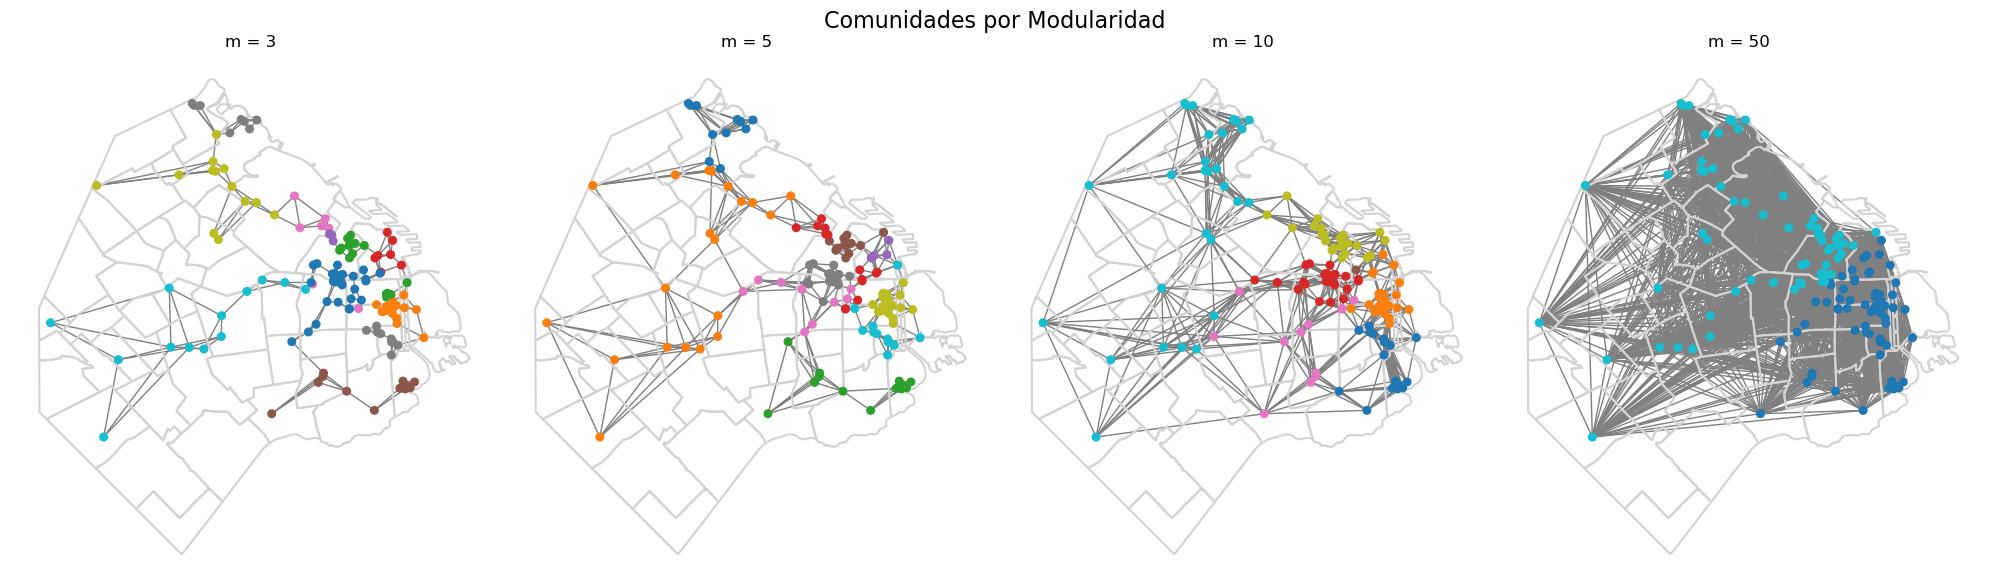

In [25]:
valores_m = [3, 5, 10, 50]
mu = 1
fig, axes = plt.subplots(1, len(valores_m), figsize=(20, 6))

for ax, m in zip(axes, valores_m):
    A = construye_adyacencia(D, m)
    A = np.ceil((A + A.T) / 2)  # simetrizamos
    L = calcula_L(A)

    # Autovector asociado al segundo autovalor más chico
    v_L, _, _ = metpotI2(L, mu)
    s_L = np.sign(v_L)

    particion_mod = modularidad_iterativo(A=A)
    comunidades = np.zeros(A.shape[0])
    for i, grupo in enumerate(particion_mod):
        for nodo in grupo:
            comunidades[nodo] = i

    G = nx.from_numpy_array(A)
    colores = comunidades.tolist()

    barrios.to_crs("EPSG:22184").boundary.plot(color='lightgray', ax=ax)
    nx.draw_networkx(
        G, pos=G_layout, ax=ax,
        node_color=colores,
        cmap='tab10',
        node_size=30,
        edge_color='gray',
        with_labels=False
    )
    ax.set_title(f"m = {m}", fontsize=12)
    ax.axis('off')

plt.suptitle("Comunidades por Modularidad", fontsize=16)
plt.tight_layout()
plt.show()


### Análisis de las comunidades por el método de la modularidad

La figura muestra cómo varía la detección de comunidades al aplicar el método de la modularidad sobre la red de museos, a medida que cambiamos el parámetro de conectividad `m`. Este método busca agrupar nodos que estén más conectados entre sí que con el resto del grafo.

Para valores bajos de `m`, como `m = 3` o `m = 5`, se identifican muchas comunidades pequeñas, lo que refleja una red con conexiones muy locales. A medida que `m` aumenta (por ejemplo en `m = 10`), algunas de esas comunidades comienzan a unirse, y para `m = 50` el grafo se vuelve tan denso que solo se detectan dos grandes grupos.

Un aspecto importante es que, a diferencia del método del laplaciano, este método permite detectar más de dos comunidades sin tener que modificar el algoritmo. Esto da como resultado una segmentación más detallada y flexible, ideal para detectar clústers naturales en redes complejas.

En resumen, el método de modularidad resulta muy útil para entender la estructura de la red: con valores bajos de `m` captura detalles locales, mientras que con valores altos da una visión más global.


C:\Users\mateo\Downloads\PROBANDO ENTREGA\Correccion_Funciones.py:40: RuntimeWarning: invalid value encountered in scalar divide
  while np.abs(l1 - l) / np.abs(l) > tol and nrep < maxrep: # Si estamos por debajo de la tolerancia buscada
C:\Users\mateo\Downloads\PROBANDO ENTREGA\Correccion_Funciones.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  l = 1 / l


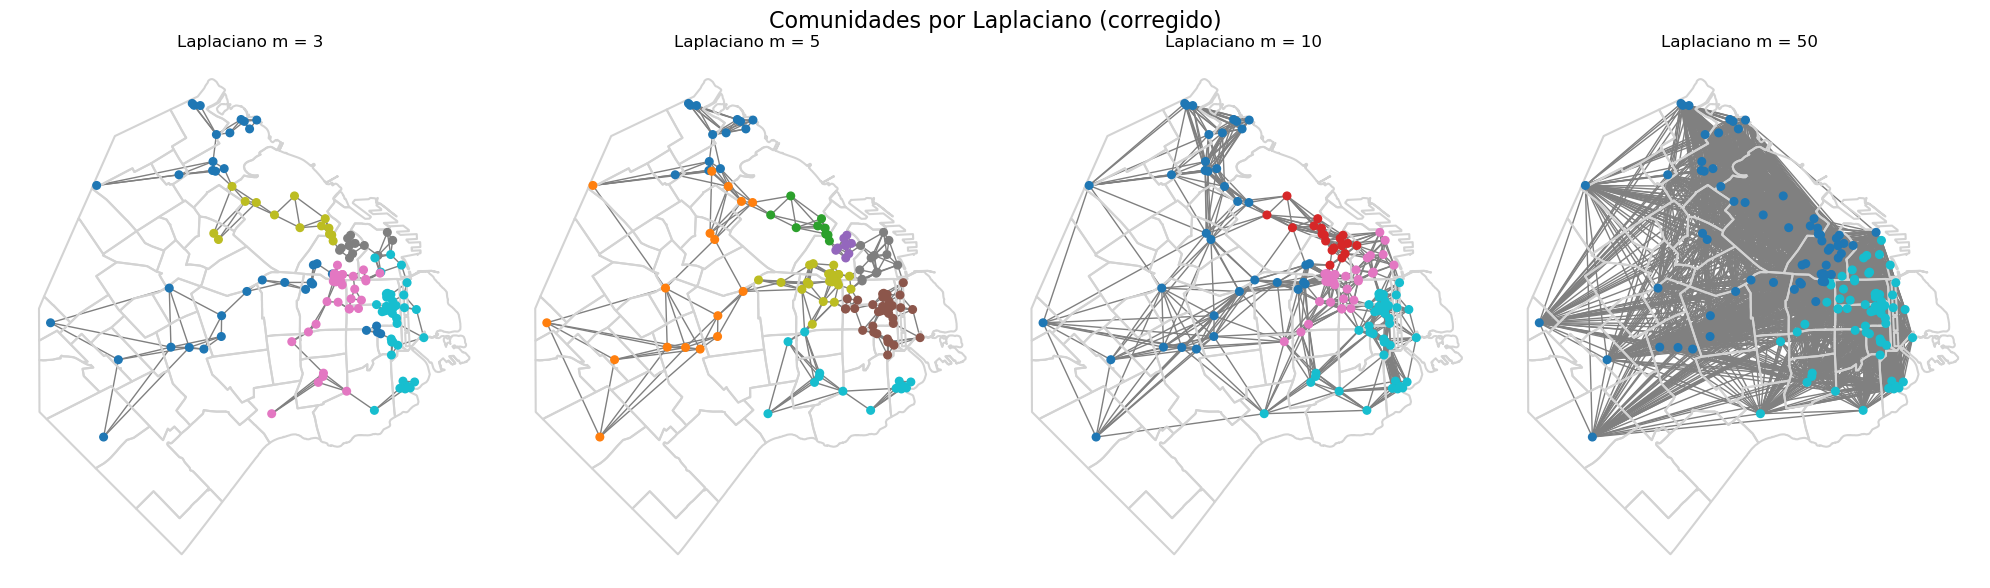

In [26]:
##################Corregido##############################

valores_m = [3, 5, 10, 50]
mu = 1
fig, axes = plt.subplots(1, len(valores_m), figsize=(20, 6))

for ax, m in zip(axes, valores_m):
    A = construye_adyacencia(D, m)
    A = np.ceil((A + A.T) / 2)  # simetrizamos

    # Obtenemos cantidad de comunidades "esperadas" usando modularidad
    comunidades_mod = modularidad_iterativo(A=A)
    niveles = int(np.log2(len(comunidades_mod)))  # Particiones binarias: 2^niveles = cantidad de comunidades (osea Si modularidad_iterativo encontró 8 comunidades: log2(8)=3)

    # Usamos laplaciano_iterativo con esa cantidad de niveles
    comunidades_lap = laplaciano_iterativo(A, niveles=niveles)

    # Codificamos comunidades como enteros para colorear
    nodos_comunidad = {}
    for i, grupo in enumerate(comunidades_lap):
        for nodo in grupo:
            nodos_comunidad[nodo] = i
    comunidades = pd.Series([nodos_comunidad[i] for i in range(A.shape[0])])

    G = nx.from_numpy_array(A)
    colores = comunidades.tolist()

    barrios.to_crs("EPSG:22184").boundary.plot(color='lightgray', ax=ax)
    nx.draw_networkx(
        G, pos=G_layout, ax=ax,
        node_color=colores,
        cmap='tab10',
        node_size=30,
        edge_color='gray',
        with_labels=False
    )
    ax.set_title(f"Laplaciano m = {m}", fontsize=12)
    ax.axis('off')

plt.suptitle("Comunidades por Laplaciano (corregido)", fontsize=16)
plt.tight_layout()
plt.show()



> VALEN: Acá tenían que usar `laplaciano_iterativo`, no calcular un solo corte a mano. Para la cantidad de niveles que le tienen que pedir a la función traten de igualar los que les da modularidad.✅

### Segmentación de comunidades por Laplaciano y Comparación metodo Modularidad

Para valores bajos de m (3 y 5), ambos métodos identifican comunidades claras y bien separadas geográficamente. Modularidad tiende a generar más particiones, revelando mas subestructuras dentro de zonas, mientras que el Laplaciano muestra divisiones un poco más amplias pero también coherentes.

A medida que aumenta m, la red se densifica y las particiones se vuelven menos nítidas. En m = 10, ambos métodos aún detectan una estructura razonable, pero la superposición de conexiones empieza a diluir los limites.

Para 𝑚 = 50, la red se vuelve casi completamente conectada. Las comunidades detectadas por ambos métodos pierden interpretación geográfica y estructural. Las divisiones que aparecen responden más a los sesgos algorítmicos que a una estructura real.

Modularidad tiende a detectar más comunidades pequeñas, mientras que el Laplaciano (cuando se controla el número de niveles) produce particiones de tamaño más parejo.



> VALEN: Vuelvan a revisar esto después de calcular las particiones bien.✅

# Punto 5. Conclusiones

En este trabajo exploramos en profundidad la red de museos de la Ciudad de Buenos Aires, utilizando herramientas de teoría de grafos y álgebra lineal aplicadas en dos etapas (TP1 y TP2). El objetivo fue entender cómo están conectados los museos entre sí, qué nodos resultan más relevantes, y cómo se agrupan naturalmente en comunidades, según distintos criterios.

En la primera parte del análisis (TP1), nos centramos en calcular el PageRank de cada museo. Esta medida refleja la importancia de un nodo dentro de la red, considerando tanto la cantidad de conexiones como el peso de los nodos que lo apuntan. Exploramos cómo cambia el PageRank al modificar dos parámetros clave: el valor de alpha (probabilidad de que un usuario “salte” a un museo aleatorio) y la conectividad m (cantidad de museos vecinos con los que se conecta cada museo).

Observamos que a medida que alpha aumenta, el PageRank tiende a igualarse entre nodos, ya que el factor aleatorio gana peso. Esto se vio claramente en la figura donde mostramos la evolución del PageRank con distintos valores de alpha: con alpha bajo, destacan los museos centrales; con alpha alto, las diferencias se suavizan. También notamos que para valores intermedios de m (por ejemplo, m = 3 o m = 5), el PageRank es más informativo, ya que la red no está ni demasiado dispersa ni excesivamente conectada.

En la segunda parte (TP2), analizamos la estructura de comunidades de la red, aplicando dos métodos distintos: uno basado en el Laplaciano del grafo y otro en la modularidad. Ambos métodos buscan detectar grupos de museos que estén más conectados entre sí que con el resto de la red, pero lo hacen desde enfoques diferentes.

##########################Corrección###################

Tras aplicar ambos métodos, observamos que tanto la modularidad como el laplaciano jerárquico permiten detectar múltiples comunidades en la red, especialmente con valores bajos de 𝑚.Con 𝑚 bajo, ambos métodos revelan comunidades pequeñas y bien delimitadas. A medida que m aumenta, la red se densifica y las particiones pierden claridad, agrupando nodos en pocas comunidades grandes. En redes densas, la interpretación se vuelve menos significativa.

Ambos enfoques son útiles: modularidad es más sensible a subdivisiones locales, mientras que el laplaciano ofrece una segmentación jerárquica más global.

> VALEN: Revisen lo del laplaciano después de arreglar los mapas.✅

En conjunto, los análisis nos permitieron observar cómo cambia la estructura de la red según las decisiones de modelado (valores de m, elección de método, etc.), y cómo distintos enfoques resaltan distintas propiedades. Aprendimos a usar medidas como PageRank, y herramientas como la potencia inversa y la deflación, para extraer información útil sobre grafos reales.

Este recorrido fue útil no solo para interpretar la red de museos, sino también para entender cómo distintas representaciones y métodos matemáticos permiten revelar patrones en estructuras complejas.